In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [3]:
x_train = pd.read_csv('/home/rashmi/Dataset/pre-processed-mfcc/s2e/audio_train.csv')
x_test = pd.read_csv('/home/rashmi/Dataset/pre-processed-mfcc/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(1704, 23)


In [4]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1704, 23) (426, 23)
{2: 505, 1: 351, 5: 303, 3: 237, 4: 159, 0: 149}


In [5]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.620
Test Set F-score =  0.634
Test Set Precision =  0.638
Test Set Recall =  0.637
Confusion matrix, without normalization
[[ 9  4  7  0  0  1]
 [ 9 35 32  0  0 15]
 [ 1 24 80  1  0 15]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 15 35  0  2 28]]


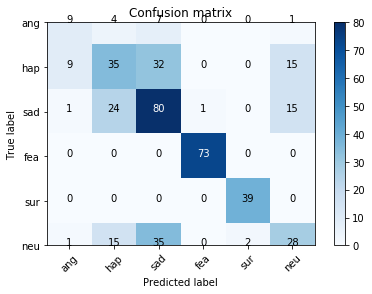

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.638
Test Set F-score =  0.664
Test Set Precision =  0.670
Test Set Recall =  0.667
Confusion matrix, without normalization
[[11  1  8  0  0  1]
 [ 7 36 36  1  1 10]
 [ 1 23 77  1  1 18]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 10 33  0  1 36]]


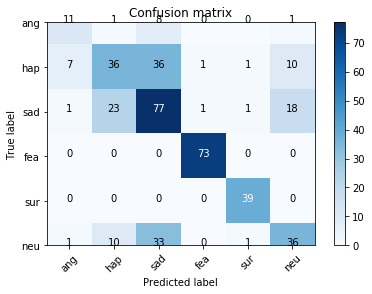

In [7]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.594
Test Set F-score =  0.606
Test Set Precision =  0.616
Test Set Recall =  0.600
Confusion matrix, without normalization
[[10  4  6  0  0  1]
 [ 6 38 25  1  2 19]
 [ 4 23 69  2  2 21]
 [ 0  0  0 73  0  0]
 [ 0  0 12  0 27  0]
 [ 1 15 26  2  1 36]]


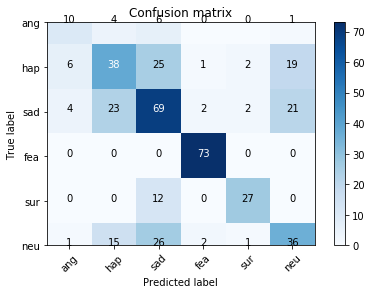

In [8]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.594
Test Set F-score =  0.606
Test Set Precision =  0.616
Test Set Recall =  0.600
Confusion matrix, without normalization
[[10  4  6  0  0  1]
 [ 6 38 25  1  2 19]
 [ 4 23 69  2  2 21]
 [ 0  0  0 73  0  0]
 [ 0  0 12  0 27  0]
 [ 1 15 26  2  1 36]]


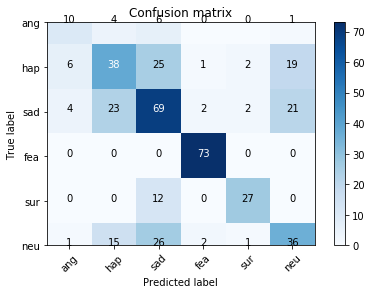

In [9]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.298
Test Set F-score =  0.131
Test Set Precision =  0.180
Test Set Recall =  0.208
Confusion matrix, without normalization
[[  5   2  14   0   0   0]
 [  6   1  84   0   0   0]
 [  0   0 121   0   0   0]
 [  0   0  73   0   0   0]
 [  0   0  39   0   0   0]
 [  0   0  81   0   0   0]]


/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


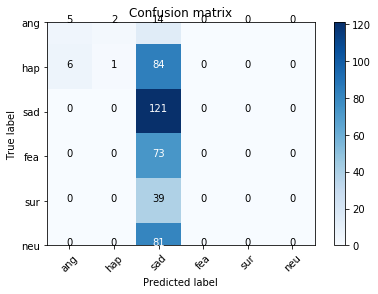

In [10]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.378
Test Set F-score =  0.352
Test Set Precision =  0.425
Test Set Recall =  0.341
Confusion matrix, without normalization
[[ 9  2  7  3  0  0]
 [ 8 26 37  7  1 12]
 [ 0 23 78  3  3 14]
 [ 0  8 39 21  0  5]
 [ 0  7 27  0  5  0]
 [ 1 12 36  8  2 22]]


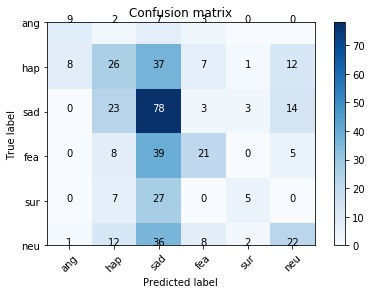

In [11]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

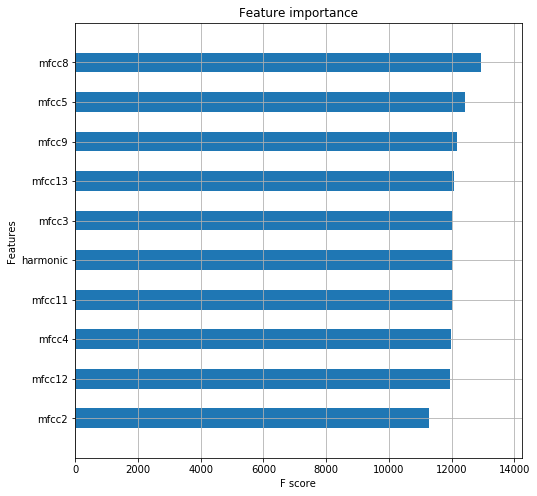

In [12]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)



In [13]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores


array([0.02758992, 0.09574676, 0.05146512, 0.04001467, 0.03211795,
       0.03711545, 0.07928383, 0.06722976, 0.0683151 , 0.04334506,
       0.03780445, 0.03571662, 0.04117934, 0.03340469, 0.04842893,
       0.03585327, 0.06046113, 0.02906769, 0.03472443, 0.03630056,
       0.06483521], dtype=float32)

In [14]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)



Stats for top 3 features:
Test Set Accuracy =  0.580
Test Set F-score =  0.598
Test Set Precision =  0.605
Test Set Recall =  0.604
Stats for top 5 features:
Test Set Accuracy =  0.599
Test Set F-score =  0.605
Test Set Precision =  0.602
Test Set Recall =  0.611
Stats for top 6 features:
Test Set Accuracy =  0.585
Test Set F-score =  0.595
Test Set Precision =  0.586
Test Set Recall =  0.607
Stats for top 7 features:
Test Set Accuracy =  0.608
Test Set F-score =  0.615
Test Set Precision =  0.606
Test Set Recall =  0.630
Stats for top 8 features:
Test Set Accuracy =  0.596
Test Set F-score =  0.612
Test Set Precision =  0.608
Test Set Recall =  0.621


Test Set Accuracy =  0.643
Test Set F-score =  0.669
Test Set Precision =  0.672
Test Set Recall =  0.670
Confusion matrix, without normalization
[[11  1  8  0  0  1]
 [ 6 38 30  1  1 15]
 [ 1 22 77  1  1 19]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 14 29  0  1 36]]


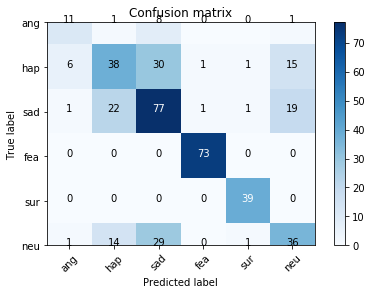

In [27]:
# Load predicted probabilities
# Load predicted probabilities
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)

In [16]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       svc_preds +
                       mnb_pred_probs)/3.0

# Show metrics
display_results(y_test, ensemble_pred_probs2)

TypeError: unsupported operand type(s) for +: 'float' and 'LinearSVC'

Test Set Accuracy =  0.631
Test Set F-score =  0.654
Test Set Precision =  0.661
Test Set Recall =  0.654
Confusion matrix, without normalization
[[10  2  8  0  0  1]
 [ 8 35 35  0  1 12]
 [ 1 25 78  1  1 15]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 11 35  0  0 34]]


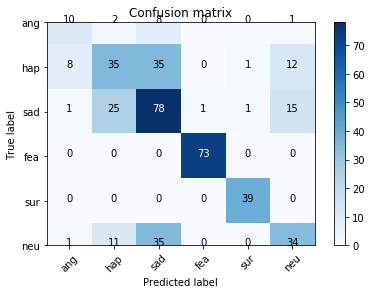

In [17]:
ensemble_pred_probs2 = (rf_pred_probs +
                       xgb_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.634
Test Set F-score =  0.653
Test Set Precision =  0.662
Test Set Recall =  0.654
Confusion matrix, without normalization
[[10  2  8  0  0  1]
 [ 3 41 29  1  1 16]
 [ 2 20 80  1  2 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 18 33  0  2 27]]


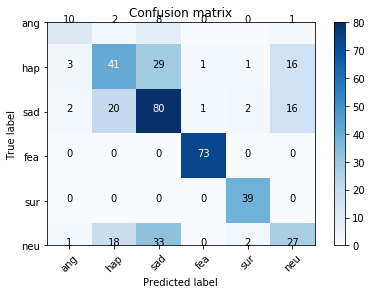

In [18]:
ensemble_pred_probs2 = (rf_pred_probs +
                       mnb_pred_probs +
                       mlp_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.585
Test Set F-score =  0.589
Test Set Precision =  0.629
Test Set Recall =  0.581
Confusion matrix, without normalization
[[ 7  4  9  0  0  1]
 [ 7 28 47  0  0  9]
 [ 0 23 88  0  0 10]
 [ 0  0  0 73  0  0]
 [ 0  2  2  0 35  0]
 [ 1 11 50  0  1 18]]


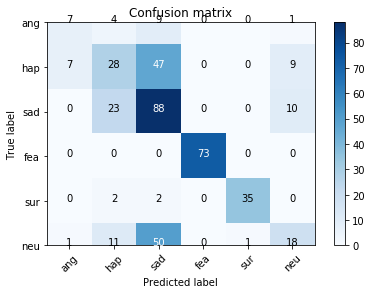

In [19]:
ensemble_pred_probs2 = (rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.629
Test Set F-score =  0.643
Test Set Precision =  0.647
Test Set Recall =  0.645
Confusion matrix, without normalization
[[ 9  3  7  0  0  2]
 [ 5 40 26  1  1 18]
 [ 2 23 78  1  1 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 17 32  0  2 29]]


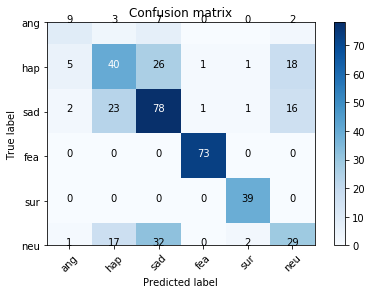

In [20]:
ensemble_pred_probs2 = (rf_pred_probs +
                       mlp_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.636
Test Set F-score =  0.660
Test Set Precision =  0.681
Test Set Recall =  0.651
Confusion matrix, without normalization
[[ 9  1 10  0  0  1]
 [ 4 37 36  1  1 12]
 [ 1 23 79  1  0 17]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 12 34  0  0 34]]


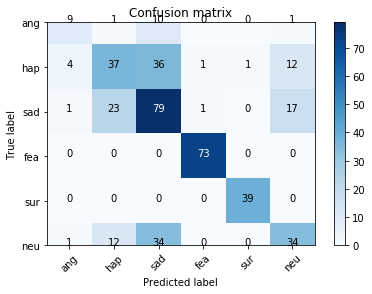

In [21]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       mnb_pred_probs +
                       mlp_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.631
Test Set F-score =  0.651
Test Set Precision =  0.673
Test Set Recall =  0.645
Confusion matrix, without normalization
[[ 9  1 10  0  0  1]
 [ 7 33 41  0  0 10]
 [ 0 24 83  1  1 12]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 10 38  0  0 32]]


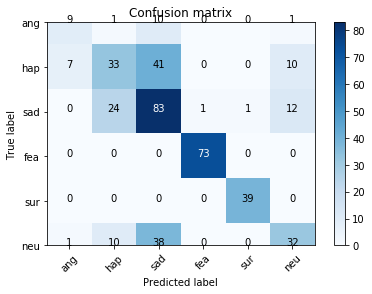

In [22]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.650
Test Set F-score =  0.677
Test Set Precision =  0.683
Test Set Recall =  0.675
Confusion matrix, without normalization
[[11  2  7  0  0  1]
 [ 5 40 28  1  1 16]
 [ 1 24 79  1  0 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 14 30  0  1 35]]


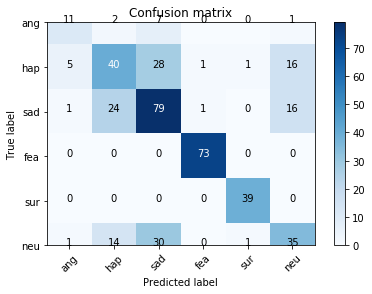

In [23]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       mlp_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.563
Test Set F-score =  0.555
Test Set Precision =  0.634
Test Set Recall =  0.529
Confusion matrix, without normalization
[[ 8  2 10  0  0  1]
 [ 3 38 35  1  1 13]
 [ 1 21 84  1  0 14]
 [ 0  0  0 73  0  0]
 [ 0  2 20  0 17  0]
 [ 1 14 43  2  1 20]]


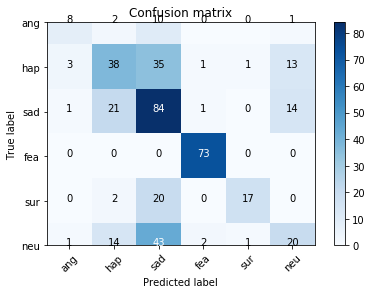

In [24]:
ensemble_pred_probs2 = (mnb_pred_probs +
                       mlp_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)